In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from ish_parser import ish_parser
from datetime import datetime, timedelta

from torch.autograd import Variable

import tensorflow as tf
from keras.models import Sequential
# from keras.layers import Dense, LSTM
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
def read_ish_file (file_path):
    wf = ish_parser()

    with open(file_path) as fp:
        file_content = fp.read()
        wf.loads(file_content)

    all_station_observations = []
    for report in wf.get_observations():
        all_station_observations.append(report)

    return all_station_observations

def get_every_hour_of_year_iso(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31, 23)

    current_date = start_date
    timestamps = []

    while current_date <= end_date:
        timestamps.append(current_date.isoformat())
        current_date += timedelta(hours=1)

    return timestamps

def save_divide(n, d):
    if d == 0:
        return None
    
    return n / d

In [3]:
def year_periodic_function(date_str):
    date_obj = datetime.strptime(date_str, "%Y-%m-%d")

    day_of_year = date_obj.timetuple().tm_yday

    phase_shift = math.pi / 2

    sin_value = math.sin((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    sin_function = 1 - (sin_value + 1) / 2

    cos_value = math.cos((2 * math.pi * (day_of_year - 1) / 365) - phase_shift)
    cos_function = 1 - (cos_value + 1) / 2

    return sin_function, cos_function

def point_on_unit_circle(degrees):
    radians = math.radians(degrees)
    x = 0.5*math.cos(radians)+0.5
    y = 0.5*math.sin(radians)+0.5
    return (x, y)

class ManyObservationAggregator():
    def __init__(self, observations, year, name):
        self.observations = observations
        self.year = year
        self.name = name
        self.hours_of_year = get_every_hour_of_year_iso(self.year)
        self.grouped_observations = self.group_observations_by_hour()
        self.rows = self.get_all_rows()

    def get_metric(self, metric_key, rolling_on=False):
        res = []
        for i in range(len(self.rows)):
            val = self.rows[i][metric_key]
            prev = val

            if rolling_on and len(res):
                prev = res[i-1]

            rolling = 0.6*(val) + 0.4 * (prev)

            res.append(rolling)

        return res

    # we group all of the observations for each hour since there may be more than observation per hour
    def group_observations_by_hour(self):
        hour_mapping = dict()
        for hour in self.hours_of_year:
            hour_mapping[hour[0:13]] = []

        for observation in self.observations:
            hour = observation.datetime.isoformat()[0:13]
            if hour in hour_mapping:
                hour_mapping[hour].append(observation)

        return hour_mapping
    
    def get_all_rows(self):
        rows = []
        for i in range(len(self.hours_of_year)):
            rows.append(self.get_row(i, rows))

        return rows
    
    def get_row(self, i, rows):
        hour = self.hours_of_year[i]
        observations_in_hour = self.grouped_observations[hour[0:13]]
        agg_observations_in_hour = self.group_list_of_observations(observations_in_hour, hour)

        # fill in missing values as the previous values
        for key, value in agg_observations_in_hour.items():
            if value is None:
                if i != 0 :
                    agg_observations_in_hour[key] = rows[i - 1][key]
                else:
                    agg_observations_in_hour[key] = 0

        return agg_observations_in_hour


    # we aggergate the datapoints in each hour window
    def group_list_of_observations(self, observations_in_hour, date):
        total_temp = 0
        num_temp = 0

        total_wind_speed = 0
        num_wind_speed = 0

        total_sky_cover = 0
        num_sky_cover = 0

        total_wind_direction = 0
        num_wind_direction = 0

        total_dew_point = 0
        num_dew_point = 0

        total_pressure = 0
        num_pressure = 0

        total_vis = 0
        num_vis = 0

        total_precipitation = 0
        num_precipitation = 0

        station = ""

        hour_of_day = float(date[11:13])
        t_sin = 0.5*math.sin(math.pi * 2 * (1/24) * (hour_of_day+6)) + 0.5
        t_cos = 0.5*math.cos(math.pi * 2 * (1/24) * (hour_of_day+6)) + 0.5
        t_sin_year, t_cos_year = year_periodic_function(date[0:10])
        has = 0

        for observation in observations_in_hour:
            station = observation.weather_station
            # we know that there is always temperature in an observation, as it is required
            if observation.air_temperature is not None and observation.air_temperature.get_fahrenheit() != "MISSING":
                total_temp += float(observation.air_temperature.get_fahrenheit())
                num_temp += 1

            if observation.wind_speed is not None and observation.wind_speed.get_MilesPerHour() is not None:
                total_wind_speed += float(observation.wind_speed.get_MilesPerHour())
                num_wind_speed += 1

            if observation.wind_speed is not None and observation.wind_speed.get_MilesPerHour() is not None:
                total_wind_speed += float(observation.wind_speed.get_MilesPerHour())
                num_wind_speed += 1

            if observation.sky_cover is not None and str(observation.sky_cover[0]["coverage"]) !=  "MISSING" and len(observation.sky_cover) > 0:
                # todo there is an observation here for each cloud type, we may want to do something
                total_sky_cover += float(str(observation.sky_cover[0]["coverage"]))
                num_sky_cover += 1

            if observation.visibility_distance is not None and str(observation.visibility_distance) !=  "MISSING":
                # todo there is an observation here for each cloud type, we may want to do something
                v = float(str(observation.visibility_distance.get_miles()))
                total_vis += float(v)
                num_vis += 1

            if observation.wind_direction is not None and str(observation.wind_direction) != "MISSING":
                total_wind_direction += float(str(observation.wind_direction))
                num_wind_direction += 1

            if observation.dew_point is not None and observation.dew_point.get_fahrenheit() != "MISSING":
                total_dew_point += float(observation.dew_point.get_fahrenheit())
                num_dew_point += 1

            if observation.sea_level_pressure is not None and str(observation.sea_level_pressure) != "MISSING":
                total_pressure += float(str(observation.sea_level_pressure))
                num_pressure += 1

            if observation.precipitation is not None and str(observation.precipitation) !=  "MISSING" and len(observation.precipitation) > 0:
                num = float(str(observation.precipitation[0]["depth"]))
                if num < 500:
                    total_precipitation += float(str(observation.precipitation[0]["depth"]))
                    num_precipitation += 1


        wind_direction_sin = None
        wind_direction_cos = None

        if num_wind_direction > 0:
            wind_direction_sin, wind_direction_cos = point_on_unit_circle(total_wind_direction / num_wind_direction)

        return {
            "station": station,
            "air_temp": save_divide(total_temp, num_temp),
            "wind_speed": save_divide(total_wind_speed, num_wind_speed),
            "sky_coverage": save_divide(total_sky_cover, num_sky_cover),
            "dew_point": save_divide(total_dew_point, num_dew_point),
            "pressure": save_divide(total_pressure, num_pressure),
            "vis": save_divide(total_vis, num_vis),
            "precip": save_divide(total_precipitation, num_precipitation),
            "wind_direction_sin": wind_direction_sin,
            "wind_direction_cos": wind_direction_cos,
            "t_sin": t_sin,
            "t_cos": t_cos,
            "t_sin_year": t_sin_year,
            "t_cos_year": t_cos_year,
        }


In [4]:
years = ["2018","2019","2020", "2021", "2022", "2023"]
stations = {
    "lax": "722950-23174",
    "lan": "723820-23182",
    "san": "722900-23188",
    "cat": "722920-23191",
    "pam": "722868-93138"
}

all_weather = {}

for (place, station_id) in stations.items():
    all_weather[place] = {}

    for year in years:
        observations = read_ish_file(f"./data/{station_id}-{year}")
        # print(f"/Users/carterharrison/Desktop/weather/{year}/{station_id}-{year}")
        all_weather[place][year] = ManyObservationAggregator(observations, int(year), place)

In [ ]:
def get_group_metric(place, years, metric):
    running = []

    for year in years:
        running = running + all_weather[place][year].get_metric(metric)

    return running

In [ ]:
from tqdm import tqdm

mps_device = torch.device("mps")

# We are not using this but would likely be good for our project (add L1/L2 norm?)
class CustomLossWithL2(nn.Module):
    def __init__(self, model, lambda_l2=0.00006):
        super(CustomLossWithL2, self).__init__()
        self.model = model
        self.lambda_l2 = lambda_l2
        self.base_loss = nn.MSELoss()  # Use MSE loss as the base loss

    def forward(self, outputs, targets):
        # Calculate the base loss
        base_loss = self.base_loss(outputs, targets)

        # # Calculate L2 regularization term
        l2_reg = torch.tensor(0.0, requires_grad=True)
        for param in self.model.parameters():
            l2_reg = l2_reg + torch.norm(param, 2)

        # Add L2 regularization term to the base loss
        total_loss = base_loss + self.lambda_l2 * l2_reg

        return base_loss

class FFWeatherModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FFWeatherModel, self).__init__()
        # self.fc1 = nn.Linear(input_size, 1444)
        self.fc2 = nn.Linear(input_size, 944)
        self.fc3 = nn.Linear(944, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, output_size)


    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))

        return x

class LSTM_Approach():
    def __init__(self, input_metrics, output_metrics, input_window_size, output_window_size):
        self.input_metrics = input_metrics
        self.output_metrics = output_metrics
        self.input_window_size = input_window_size
        self.output_window_size = output_window_size

        self.model = tf.keras.Sequential([
            tf.keras.layers.LSTM(100, input_shape=(self.input_window_size, len(self.input_metrics)), 
                                 return_sequences=True),
            tf.keras.layers.LSTM(100),
            # tf.keras.layers.Dense(4*self.output_window_size, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)),
            # tf.keras.layers.Dense(2*self.output_window_size, kernel_regularizer=tf.keras.regularizers.L2(l2=1e-4)),
            # tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(self.output_window_size)
        ])

    def train(self, inputs, outputs, v_in, v_out, epochs=50, stop_early=False):
        trimmed_x =  inputs[:int(len(inputs)*.8)]
        trimmed_y = outputs[:int(len(outputs)*.8)][:,:,0]

        if stop_early:
          callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
          self.model.fit(np.array(trimmed_x), np.array(trimmed_y), epochs=epochs, callbacks=[callback])
        else:
          self.model.fit(np.array(trimmed_x), np.array(trimmed_y), epochs=epochs)

    def evaluate(self, inputs, outputs):
        trimmed_x = inputs[int(len(inputs)*.8):]
        trimmed_y = outputs[int(len(outputs)*.8):][:,:,0]
        self.model.evaluate(trimmed_x, trimmed_y)

    def predict(self, x_list):
        return self.model.predict(x_list, verbose=0)
    
    def calculate_loss(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32).to(mps_device)
        Y = torch.tensor(Y, dtype=torch.float32).to(mps_device)

        criterion = CustomLossWithL2(self.model)
        self.model.eval() 
        
        with torch.no_grad():
            outputs = self.model(X)
            loss = criterion(outputs, Y)
        
        return loss.item()

# class FFWeatherModelHybrid(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(FFWeatherModelHybrid, self).__init__()
#         # self.lstm = nn.LSTM(input_size=input_size, hidden_size=input_size, num_layers=1, batch_first=True)
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=2, num_layers=1, batch_first=True)
#         # self.fc2 = nn.Linear(input_size, 944)
#         # self.fc3 = nn.Linear(944, 512)
#         # self.fc4 = nn.Linear(512, 256)
#         # self.fc5 = nn.Linear(256, 128)
#         self.fc6 = nn.Linear(2, output_size)


#     def forward(self, x):
#         # x = torch.relu(self.fc1(x))
#         x, _ = self.lstm(x)
#         # x = torch.relu(self.fc2(x))
#         # x = torch.relu(self.fc3(x))
#         # x = torch.relu(self.fc4(x))
#         # x = torch.relu(self.fc5(x))
#         x = torch.sigmoid(self.fc6(x))

#         return x
    
# class LSTM(nn.Module):

#     def __init__(self, input_size, output_size): 
#         super(LSTM, self).__init__()
        
#         self.num_classes = output_size
#         self.num_layers = 1
#         self.input_size = input_size
#         self.hidden_size = 2
#         self.seq_length = 72
        
#         self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size,
#                             num_layers=self.num_layers, batch_first=True)
        
#         self.fc = nn.Linear(self.hidden_size, self.num_classes)

#     def forward(self, x):
#         h_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size))
        
#         c_0 = Variable(torch.zeros(
#             self.num_layers, x.size(0), self.hidden_size))
        
#         # Propagate input through LSTM
#         ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
#         h_out = h_out.view(-1, self.hidden_size)
        
#         out = self.fc(h_out)
        
#         return out
    
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class FFTrainer():
    def __init__(self, model):
        self.model = model.to(mps_device)

    def train(self, x_list, y_list, v_in, v_out, epochs, batch_size):
        self.losses = []
        self.validation_losses = []
        criterion = CustomLossWithL2(self.model)
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        early_stopper = EarlyStopper(patience=1, min_delta=1)

        X = torch.tensor(x_list, dtype=torch.float32).to(mps_device)
        Y = torch.tensor(y_list, dtype=torch.float32).to(mps_device)

        progress_bar = tqdm(total=epochs, desc='Training', leave=False, ncols=110, unit='epoch')

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = self.model(X)
            loss = criterion(outputs, Y)

            self.losses.append(loss.cpu().detach().numpy())
            validation_loss = self.calculate_loss(v_in, v_out)
            if early_stopper.early_stop(validation_loss):
                print("Stopped early")
                break
            self.validation_losses.append(validation_loss)

            loss.backward()
            optimizer.step()

            progress_bar.set_postfix({
                'Loss': loss.item(),
                'Validation Loss': self.validation_losses[len(self.validation_losses) - 1]
            })
            progress_bar.update(1)

        progress_bar.close()

    def predict(self, x_list):
        X = torch.tensor(x_list, dtype=torch.float32).to(mps_device)
        return self.model(X).cpu().detach().numpy()
    
    def calculate_loss(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32).to(mps_device)
        Y = torch.tensor(Y, dtype=torch.float32).to(mps_device)

        criterion = CustomLossWithL2(self.model)
        self.model.eval() 
        
        with torch.no_grad():
            outputs = self.model(X)
            loss = criterion(outputs, Y)
        
        return loss.item()

In [ ]:
def chunk_all_inputs(arrays):
    max_window_size = 0
    for array in arrays:
        if array[1] > max_window_size:
            max_window_size = array[1]

    chunks = []

    for k in range(len(arrays[0][0]) - max_window_size + 1):
        ending_index = k + max_window_size - 1

        chunk = []
        for array in arrays:
            data = array[0]
            window_size = array[1]

            for i in range(window_size):
                data_point = data[ending_index - window_size + i + 1]
                chunk.append(data_point)

        chunks.append(chunk)

    return chunks

def chunk_list_output(lst, input_size, n):
    input_chunks = []

    for i in range(len(lst) - (2*input_size) + 1):
        input_row = []

        for j in range(n):
            input_row.append(lst[input_size+i+j])

        input_chunks.append(input_row)

    return input_chunks


class FFChunkWindowModel():
    def __init__(self, input_metrics, output_metrics, validation_input_metrics, validation_output_metrics, output_window_size):
        self.input_metrics = input_metrics
        self.output_metrics = output_metrics
        self.validation_input_metrics = validation_input_metrics
        self.validation_output_metrics = validation_output_metrics
        self.output_window_size = output_window_size

        self.model = FFWeatherModel(self.num_inputs(), self.num_outputs())
        self.trainer = FFTrainer(self.model)

    def num_inputs(self):
        num = 0
        for metrics in self.input_metrics:
            num += metrics[1]
        return num
    
    def num_outputs(self):
        return len(self.output_metrics) * self.output_window_size
    
    def train(self, epochs, batch_size):
        (inputs, outputs) = self.get_training_data(self.input_metrics, self.output_metrics)
        (v_in, v_out) = self.get_training_data(self.validation_input_metrics, self.validation_output_metrics)
        self.trainer.train(np.array(inputs), np.array(outputs), np.array(v_in), np.array(v_out), epochs, batch_size)

    def predict(self, input):
         return self.trainer.predict(input)

    def predit_at_time(self, time, data):
        points = []

        for timeseries in data:
            series = timeseries[0]
            size = timeseries[1]

            points.append(series[time - size:time])

        input_vec = np.concatenate(points).reshape(1, -1)
        predicted = self.predict(input_vec)
        return predicted
    
    def loss_of_dataset(self, input_metrics, output_metrics):
        (input, output) = self.get_training_data(input_metrics, output_metrics)
        return self.trainer.calculate_loss(input, output)

    def get_training_data(self, input_metrics, output_metrics):
        all_input_chunks = chunk_all_inputs(input_metrics)
        all_output_chunks = chunk_all_inputs([(output_metrics[0], self.output_window_size)])

        inputs = all_input_chunks
        outputs = all_output_chunks

        max_window_size = 0
        for array in input_metrics:
            if array[1] > max_window_size:
                max_window_size = array[1]

        outputs = outputs[max_window_size:]
        inputs = inputs[:len(outputs)]

        pairs = list(zip(inputs, outputs))

        random.shuffle(pairs)

        shuffled_inputs, shuffled_outputs = zip(*pairs)

        shuffled_inputs = list(shuffled_inputs)
        shuffled_outputs = list(shuffled_outputs)
        

        return (shuffled_inputs, shuffled_outputs)

In [ ]:
def norm(x):
    mean = np.mean(x)
    std = np.std(x)
    s = (x - mean)/std
    
    max = np.max(s)
    min = np.min(s)

    return (s-min)/(max-min)

def denorm(all, x):
    mean = np.mean(all)
    std = np.std(all)
    s = (all - mean)/std
    max = np.max(s)
    min = np.min(s)
    mid = ((x * (max-min)) + min)
    return (mid*std) + mean


class WeatherRunner():
    def __init__(self, input_metrics, output_metrics):
        self.input_metrics = input_metrics
        self.output_metrics = output_metrics
        self.train_years = ["2018", "2019", "2020", "2021"]
        self.validation_years = ["2022"]
        self.test_years = ["2023"]
        self.model = self.make_model()
        self.trained = False

    def make_model(self):
        (inputs, outputs) = self.get_inputs_and_outputs(self.train_years)
        (validation_inputs, validation_outputs) = self.get_inputs_and_outputs(self.validation_years)

        return FFChunkWindowModel(
            inputs,
            outputs,
            validation_inputs,
            validation_outputs,
            self.output_metrics[len(self.output_metrics) - 1][2]
        )
    
    def get_inputs_and_outputs(self, years):
        inputs = self.get_year_data_with_window(years, self.input_metrics)
        outputs = []

        for output_metric in self.output_metrics:
            place = output_metric[0]
            key = output_metric[1]
            outputs.append(norm(get_group_metric(place, years, key)))

        return (inputs, outputs)
    
    def get_test_loss (self):
        inputs = self.get_year_data_with_window(self.test_years, self.input_metrics)
        outputs = []

        for output_metric in self.output_metrics:
            place = output_metric[0]
            key = output_metric[1]
            outputs.append(norm(get_group_metric(place, self.test_years, key)))

        return self.model.loss_of_dataset(inputs, outputs)

    def get_year_data_with_window(self, years, metrics, should_norm = True):
        res  = []
        for metric in metrics:
            place = metric[0]
            key = metric[1]
            window_size = metric[2]
            normed = get_group_metric(place, years, key)

            if should_norm:
                normed = norm(normed)
                
            res.append((normed, window_size))
        
        return res

    def train (self, epocs = 100):
        self.model.train(epocs, self.model.num_inputs())
        self.trained = True

    def show_loss_over_epocs(self):
        plt.ylabel("Loss (MSE + L2)")
        plt.xlabel("Epocs")
        plt.plot(self.model.trainer.losses[:], label="Training Loss")
        plt.plot(self.model.trainer.validation_losses[:], label="Validation Loss")
        plt.legend()
        plt.figure()
    
    def plot_predictions_at_random_point(self):
        test_data = self.get_year_data_with_window(self.test_years, self.input_metrics)
        output_data = self.get_year_data_with_window(self.test_years, self.output_metrics, False)

        i = random.randint(0, len(test_data[0][0]))
        predicted = self.model.predit_at_time(i, test_data)

        for (j, datapoints) in enumerate(output_data):
            actual = datapoints[0]
            metric_name = self.output_metrics[j][1]
            
            predicted_x = 72 + np.arange(0, self.model.output_window_size) 
            predicted_f = denorm(actual, predicted[0])
            real = actual[i - 72: i + self.model.output_window_size]
            real_f = np.array(real)

            plt.rcParams['figure.figsize'] = [16, 3]
            plt.rcParams['figure.dpi'] = 100
            plt.plot(predicted_x, predicted_f, label="Predicted " + metric_name, color="green")
            real_x = np.arange(0, len(real_f))
            plt.plot(real_x, real_f, label="Actual " + metric_name)

            plt.axvline(72, color="red")
            plt.ylabel(metric_name)
            plt.xlabel("Time (hours)")
            plt.legend()
            plt.figure()

class Level ():
    def __init__(self, input_metrics, output_metrics, epocs):
        self.runner = WeatherRunner(input_metrics, output_metrics)
        self.runner.train(epocs)

        print("-----------------------------------------------------------------------------")
        l1 = self.runner.model.trainer.losses[len(self.runner.model.trainer.losses) - 1]
        l2 = self.runner.get_test_loss()
        print("Training Set Loss:", round(float(l1), 6))
        print("Test Set Loss:", round(float(l2), 6))
        self.runner.show_loss_over_epocs()

        for i in range (5):
            plt.title("Example " + str(i))
            self.runner.plot_predictions_at_random_point()

# Predicting perfect periodic function
We expect this to match very close

-----------------------------------------------------------------------------
Training Set Loss: 0.134046
Test Set Loss: 0.134034


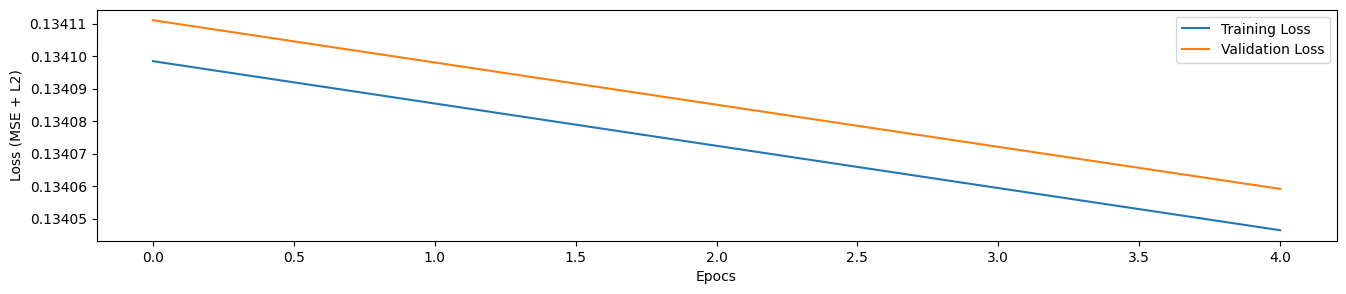

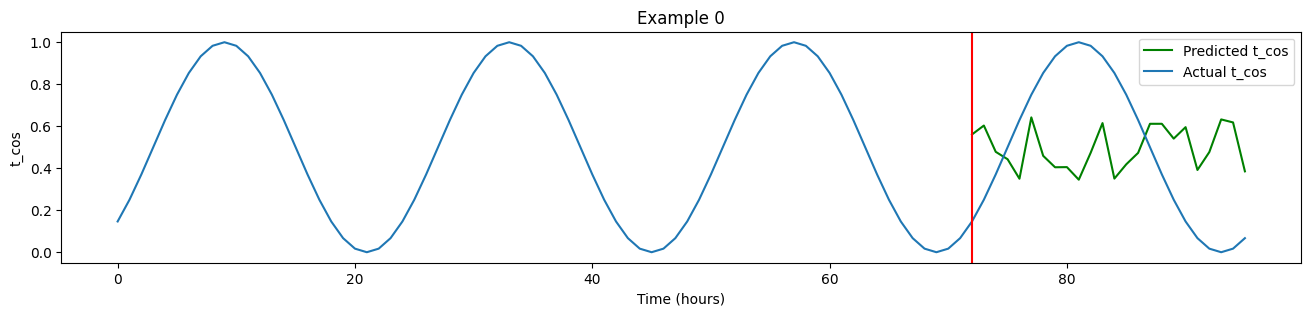

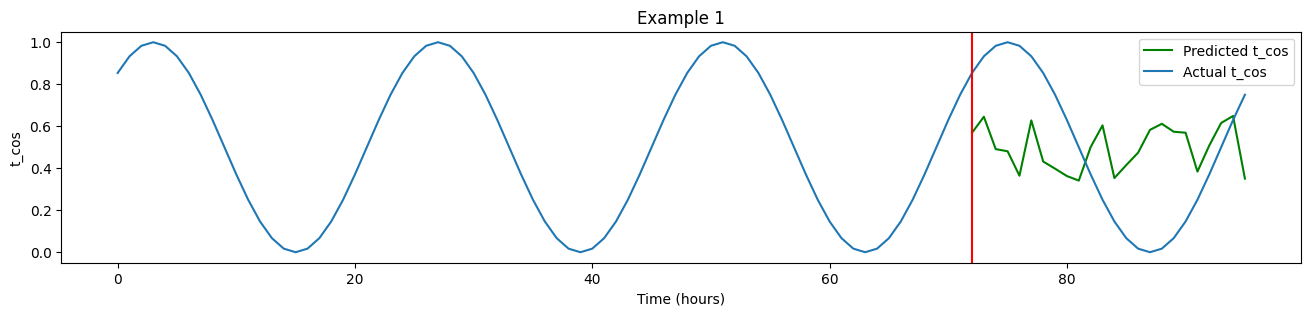

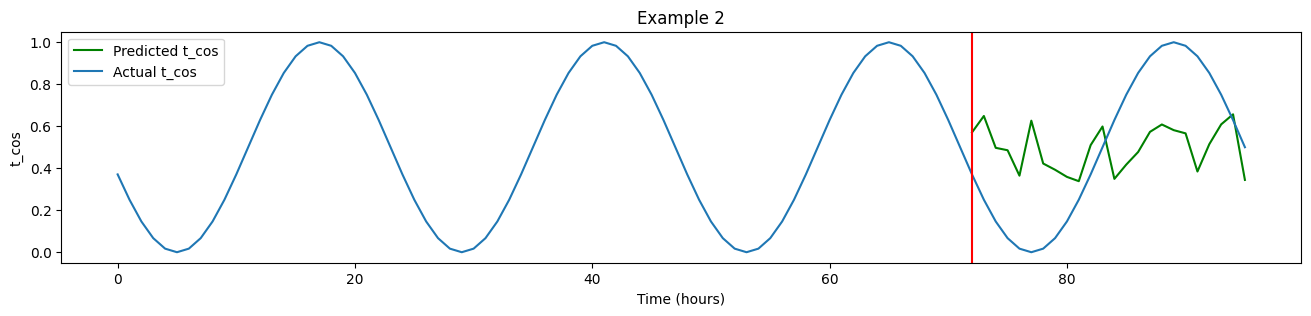

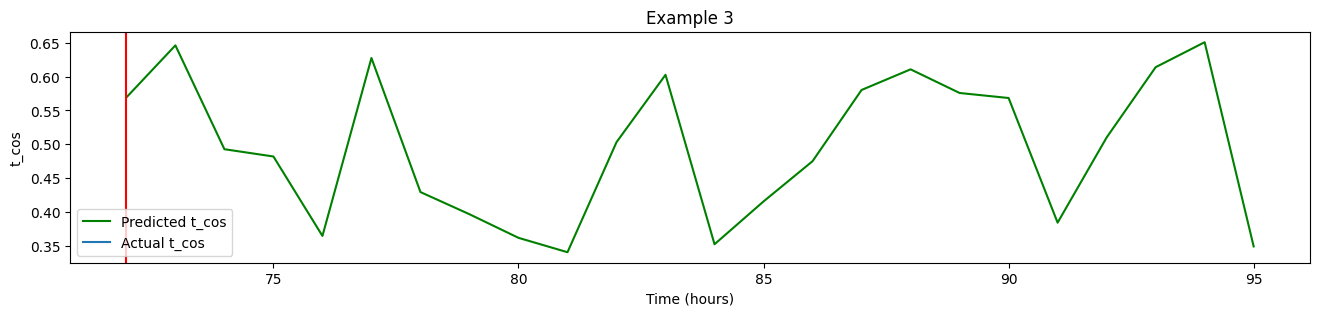

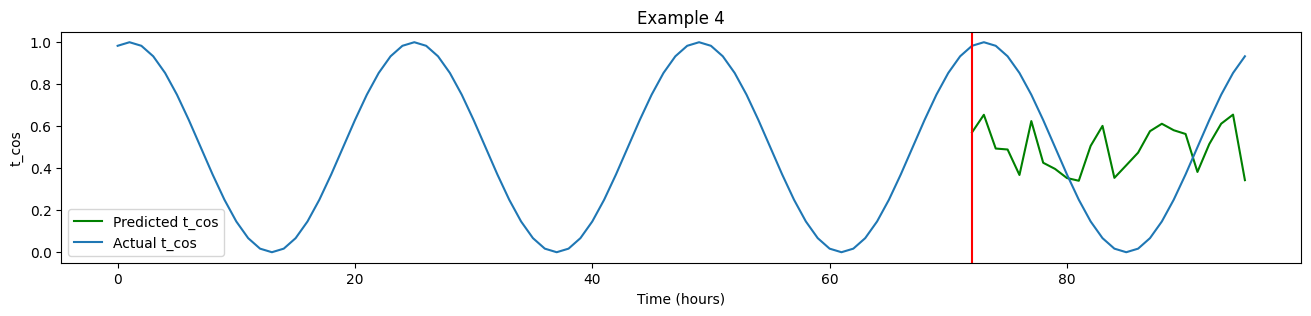

<Figure size 1600x300 with 0 Axes>

In [ ]:
level_1 = Level([("lax", "t_sin", 24)], [("lax", "t_cos", 24)], 1000)

# Predicting temperature 24 hours into the future only based on time of day and season
We expect this to follow somewhat of the generel shape

In [ ]:
level_2 = Level([
    ("lax", "t_sin", 1),
    ("lax", "t_cos", 1),
    ("lax", "t_sin_year", 1),
    ("lax", "t_cos_year", 1)
], [("lax", "air_temp", 24)], 200)

Training:   1%|▏                      | 2/200 [00:04<06:31,  1.98s/epoch, Loss=0.0247, Validation Loss=0.0352]

KeyboardInterrupt: 

# Predicting temperature 24 hours into the future based on time of day, season, and past 24 hours of temp
We expect this to have a correct shape, shifted to the correct tempature. Yet only follow the pattern of the previous day


-----------------------------------------------------------------------------
Training Set Loss: 0.005854
Test Set Loss: 0.006551


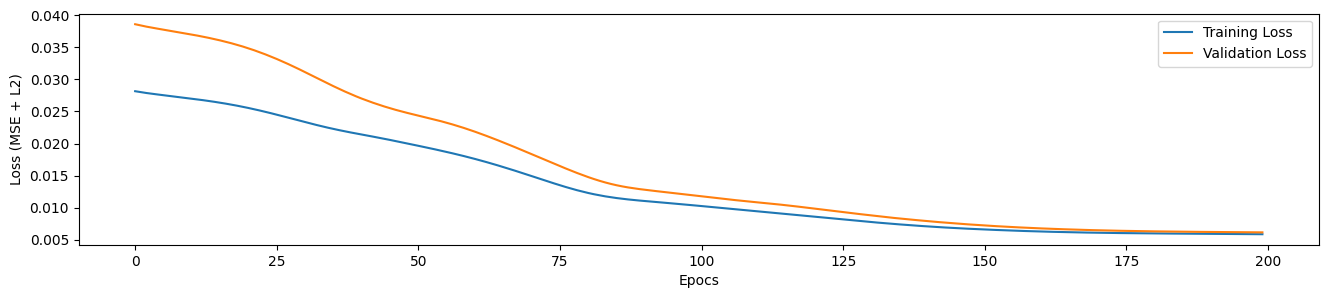

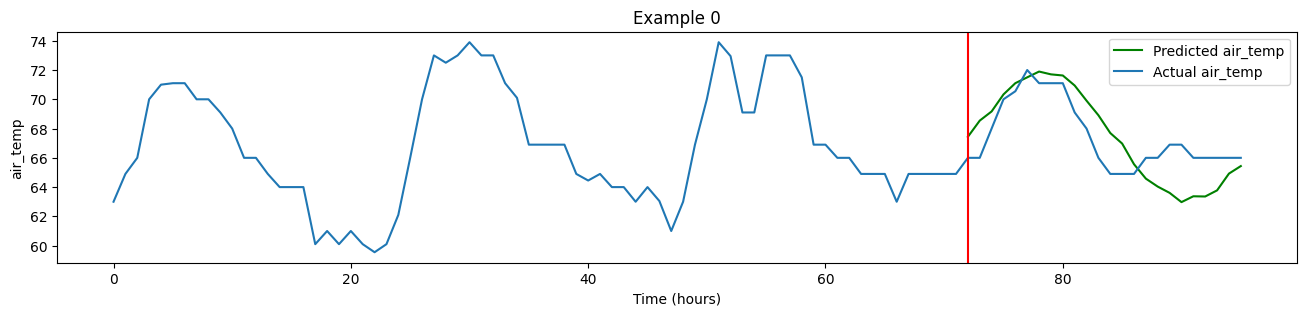

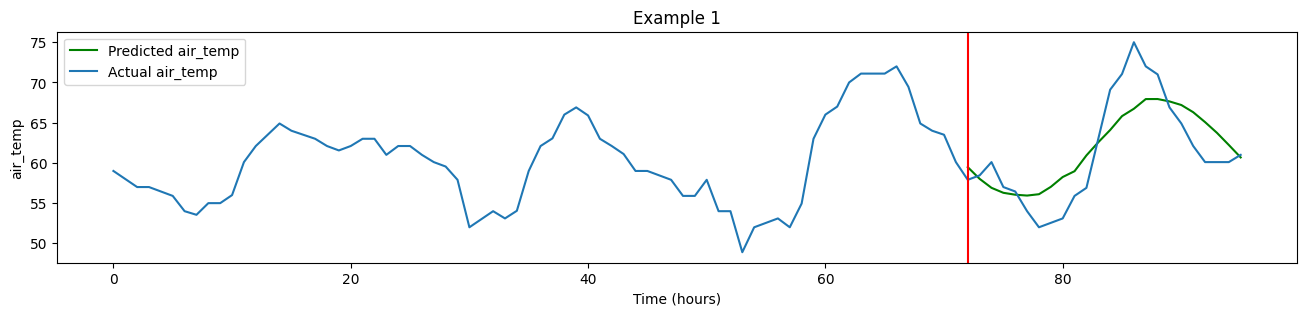

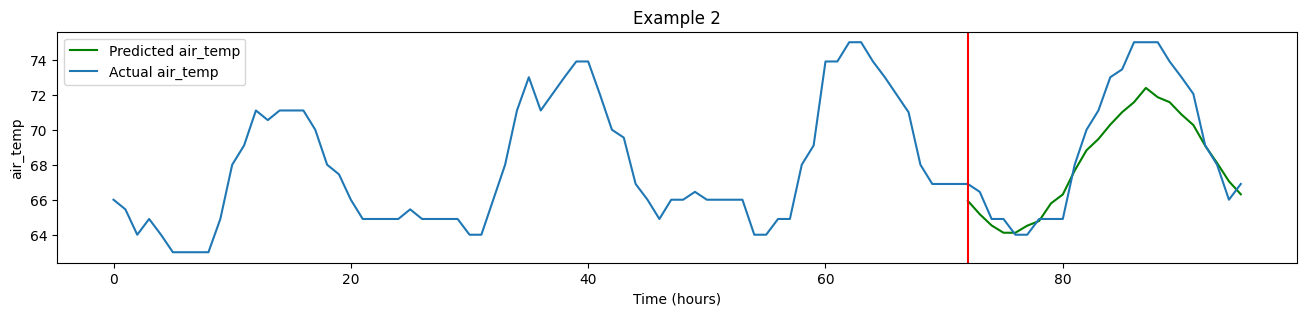

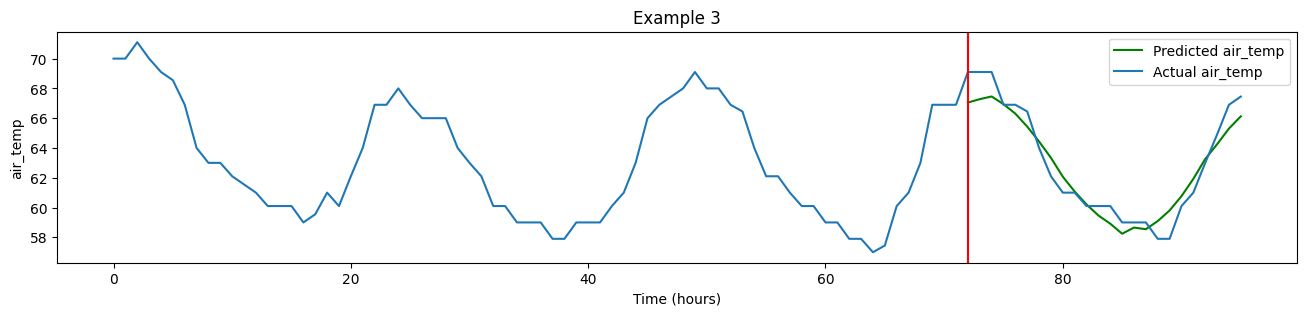

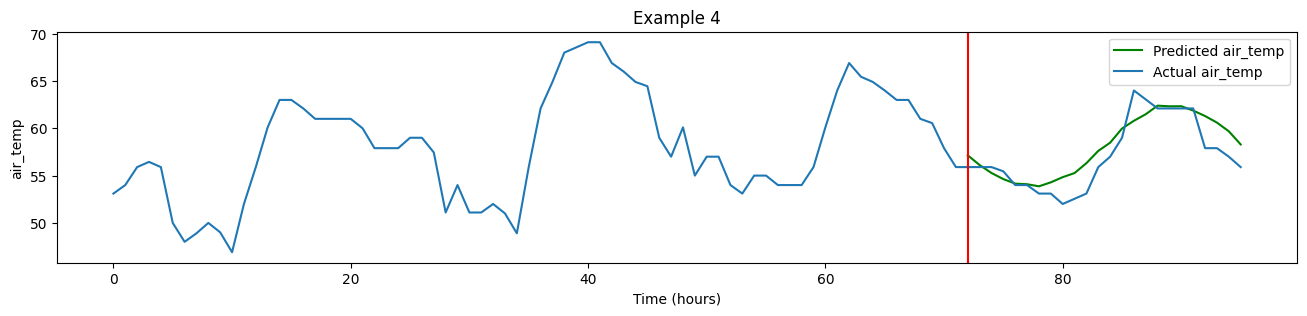

<Figure size 1600x300 with 0 Axes>

In [ ]:
level_3 = Level([
    ("lax", "air_temp", 24),

    ("lax", "t_sin", 1),
    ("lax", "t_cos", 1),
    ("lax", "t_sin_year", 1),
    ("lax", "t_cos_year", 1)
], [("lax", "air_temp", 24)], 200)

# Predicting temperature 24 hours into the future based on all weather metrics at the same weather station
We expect the same pattern ad above but slightly more accurate

-----------------------------------------------------------------------------
Training Set Loss: 0.00479
Test Set Loss: 0.007368


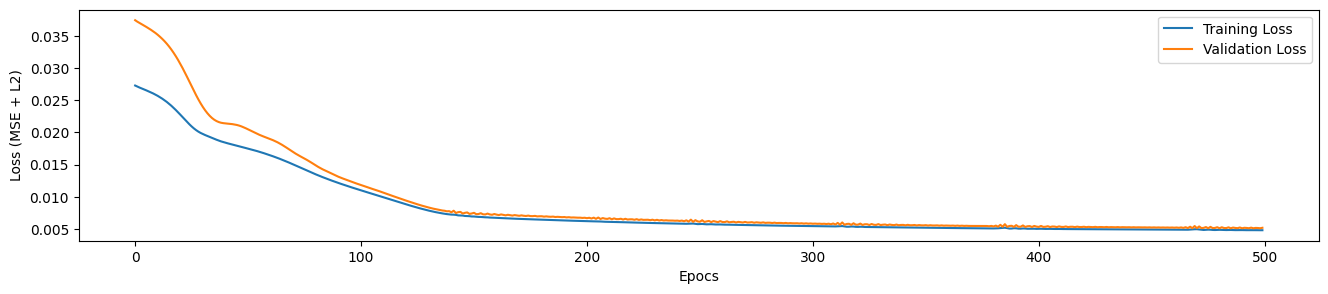

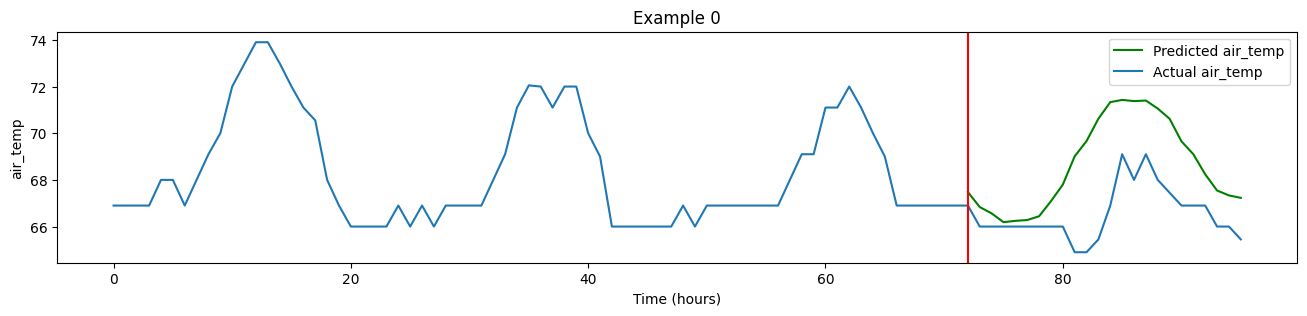

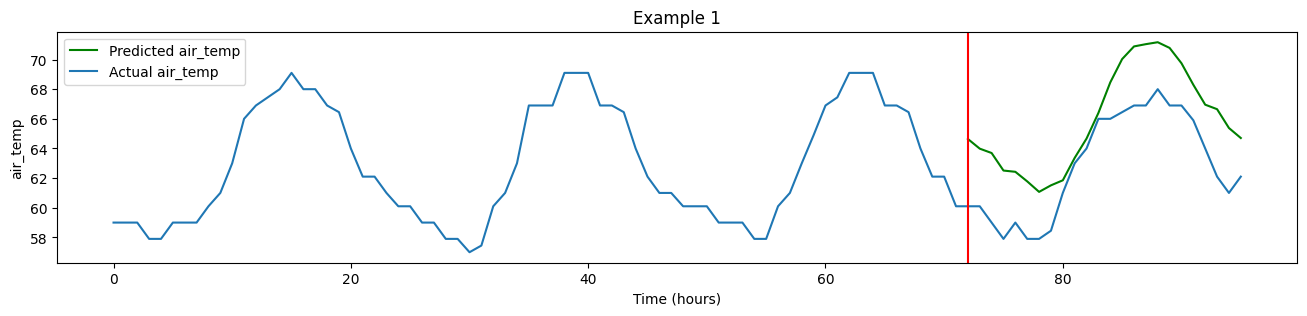

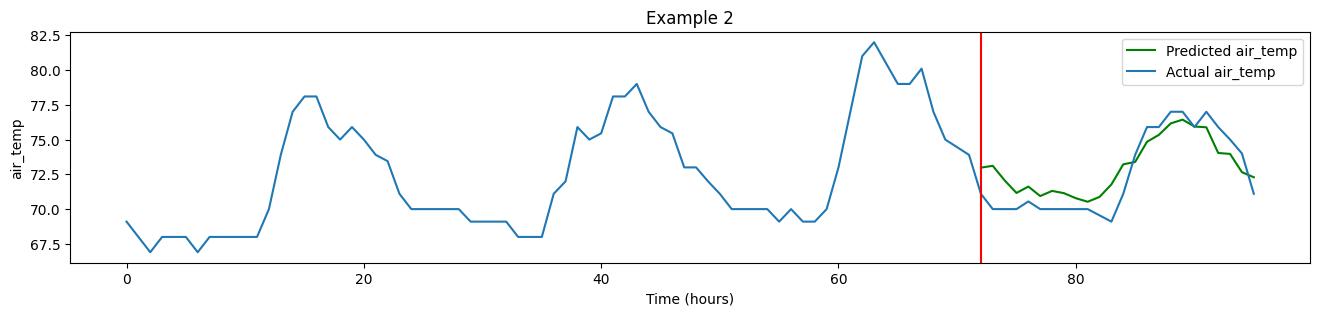

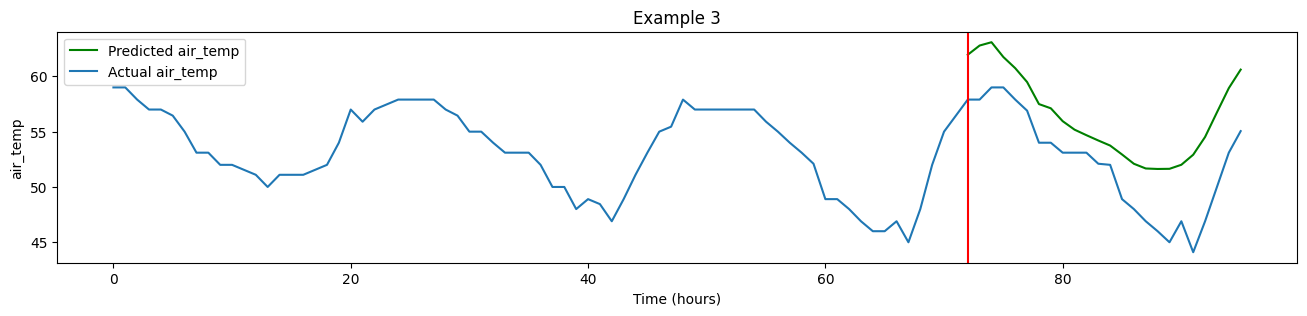

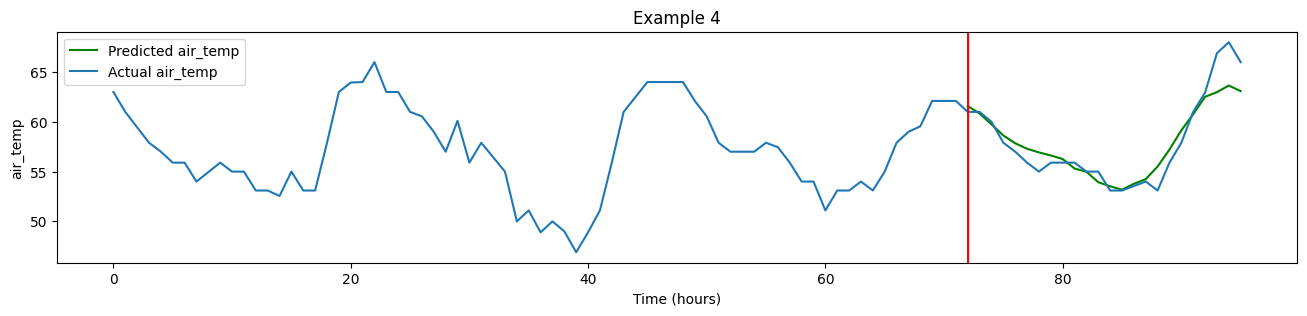

<Figure size 1600x300 with 0 Axes>

In [ ]:
level_4 = Level([
    ("lax", "air_temp", 24),
    ("lax", "wind_speed", 24),
    ("lax", "sky_coverage", 24),
    ("lax", "dew_point", 24),
    ("lax", "pressure", 24),
    ("lax", "vis", 24),
    ("lax", "wind_direction_sin", 24),
    ("lax", "wind_direction_cos", 24),
    ("lax", "precip", 24),

    ("lax", "t_sin", 1),
    ("lax", "t_cos", 1),
    ("lax", "t_sin_year", 1),
    ("lax", "t_cos_year", 1)
], [("lax", "air_temp", 24)], 500)

# Predicting temperature 24 hours into the future based on all weather metrics including 4 other weather stations
We expect the same pattern ad above but slightly more accurate

In [ ]:
level_5 = Level([
        ("lax", "air_temp", 24),
        ("lax", "wind_speed", 24),
        ("lax", "sky_coverage", 24),
        ("lax", "dew_point", 24),
        ("lax", "pressure", 24),
        ("lax", "vis", 24),
        ("lax", "wind_direction_sin", 24),
        ("lax", "wind_direction_cos", 24),
        ("lax", "precip", 24),

        ("san", "air_temp", 24),
        ("san", "wind_speed", 24),
        ("san", "sky_coverage", 24),
        ("san", "dew_point", 24),
        ("san", "pressure", 24),
        ("san", "vis", 24),
        ("san", "wind_direction_sin", 24),
        ("san", "wind_direction_cos", 24),
        ("san", "precip", 24),

        ("lan", "air_temp", 24),
        ("lan", "wind_speed", 24),
        ("lan", "sky_coverage", 24),
        ("lan", "dew_point", 24),
        ("lan", "pressure", 24),
        ("lan", "vis", 24),
        ("lan", "wind_direction_sin", 24),
        ("lan", "wind_direction_cos", 24),
        ("lan", "precip", 24),

        ("cat", "air_temp", 24),
        ("cat", "wind_speed", 24),
        ("cat", "sky_coverage", 24),
        ("cat", "dew_point", 24),
        ("cat", "pressure", 24),
        ("cat", "vis", 24),
        ("cat", "wind_direction_sin", 24),
        ("cat", "wind_direction_cos", 24),
        ("cat", "precip", 24),

        ("pam", "air_temp", 24),
        ("pam", "wind_speed", 24),
        ("pam", "sky_coverage", 24),
        ("pam", "dew_point", 24),
        ("pam", "pressure", 24),
        ("pam", "vis", 24),
        ("pam", "wind_direction_sin", 24),
        ("pam", "wind_direction_cos", 24),
        ("pam", "precip", 24),

        ("lax", "t_sin", 1),
        ("lax", "t_cos", 1),
        ("lax", "t_sin_year", 1),
        ("lax", "t_cos_year", 1)
    ],
    [
        ("lax", "air_temp", 24),
    ],
    2_000
)

Training:  43%|████████▏          | 860/2000 [02:34<03:18,  5.73epoch/s, Loss=0.0038, Validation Loss=0.00435]

KeyboardInterrupt: 

# Predicting temperature 24 hours into the future based on all weather metrics including 4 other weather stations going back 3 days
We expect the same pattern ad above but slightly more accurate

In [ ]:
level_6 = Level([
        ("lax", "air_temp", 72),
        ("lax", "wind_speed", 72),
        ("lax", "sky_coverage", 72),
        ("lax", "dew_point", 72),
        ("lax", "pressure", 72),
        ("lax", "vis", 72),
        ("lax", "wind_direction_sin", 72),
        ("lax", "wind_direction_cos", 72),
        ("lax", "precip", 72),

        ("san", "air_temp", 72),
        ("san", "wind_speed", 72),
        ("san", "sky_coverage", 72),
        ("san", "dew_point", 72),
        ("san", "pressure", 72),
        ("san", "vis", 72),
        ("san", "wind_direction_sin", 72),
        ("san", "wind_direction_cos", 72),
        ("san", "precip", 72),

        ("lan", "air_temp", 72),
        ("lan", "wind_speed", 72),
        ("lan", "sky_coverage", 72),
        ("lan", "dew_point", 72),
        ("lan", "pressure", 72),
        ("lan", "vis", 72),
        ("lan", "wind_direction_sin", 72),
        ("lan", "wind_direction_cos", 72),
        ("lan", "precip", 72),

        ("cat", "air_temp", 72),
        ("cat", "wind_speed", 72),
        ("cat", "sky_coverage", 72),
        ("cat", "dew_point", 72),
        ("cat", "pressure", 72),
        ("cat", "vis", 72),
        ("cat", "wind_direction_sin", 72),
        ("cat", "wind_direction_cos", 72),
        ("cat", "precip", 72),

        ("pam", "air_temp", 72),
        ("pam", "wind_speed", 72),
        ("pam", "sky_coverage", 72),
        ("pam", "dew_point", 72),
        ("pam", "pressure", 72),
        ("pam", "vis", 72),
        ("pam", "wind_direction_sin", 72),
        ("pam", "wind_direction_cos", 72),
        ("pam", "precip", 72),

        ("lax", "t_sin", 1),
        ("lax", "t_cos", 1),
        ("lax", "t_sin_year", 1),
        ("lax", "t_cos_year", 1)
    ],
    [
        ("lax", "air_temp", 24),
    ],
    1_000
)

KeyboardInterrupt: 

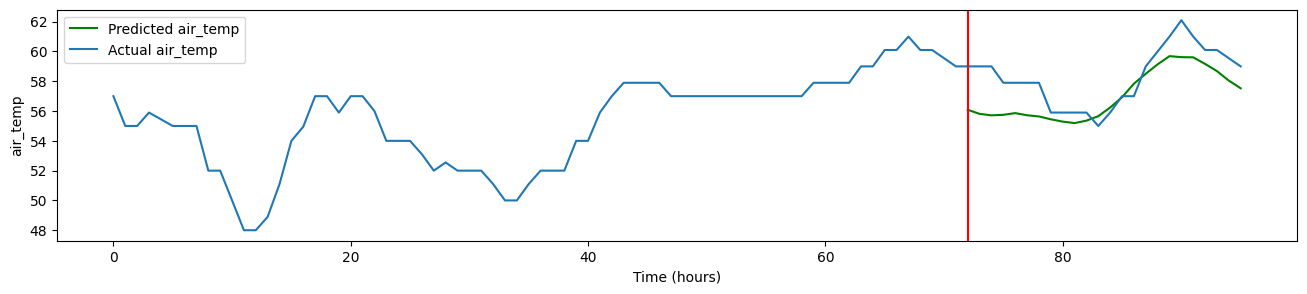

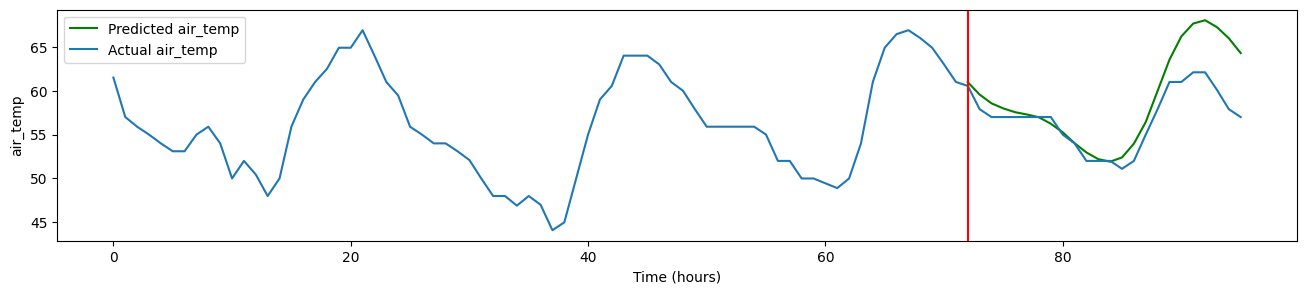

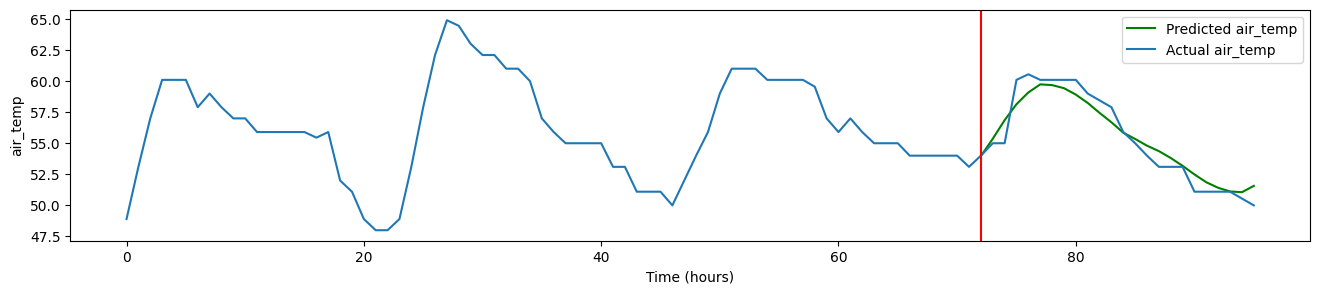

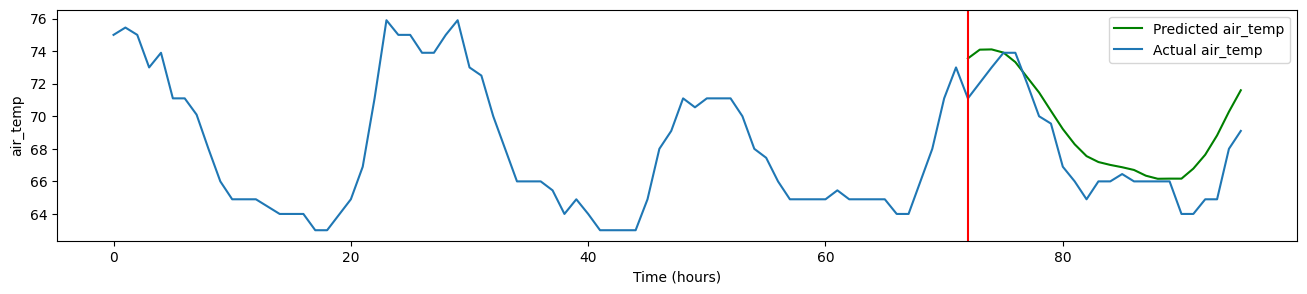

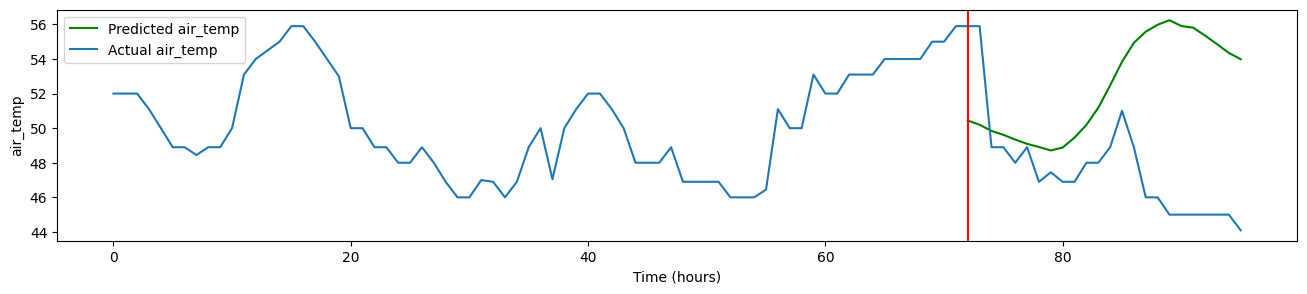

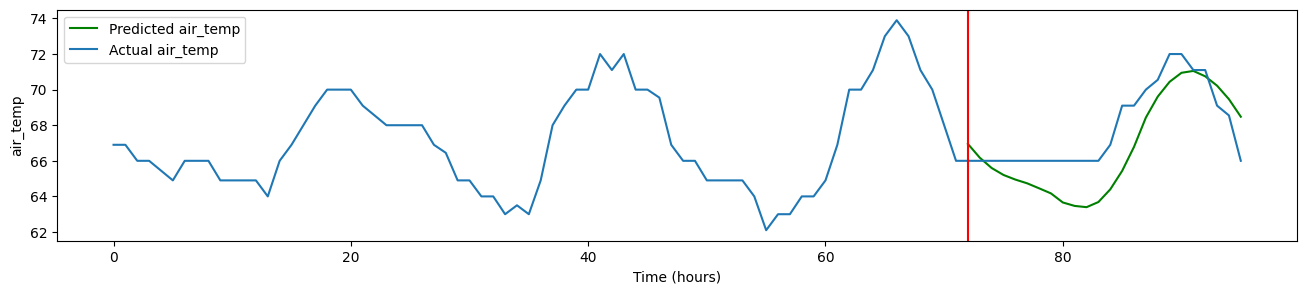

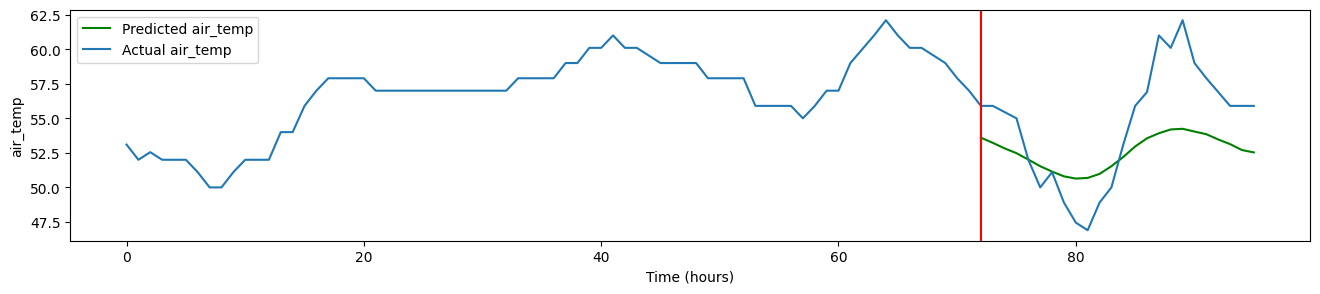

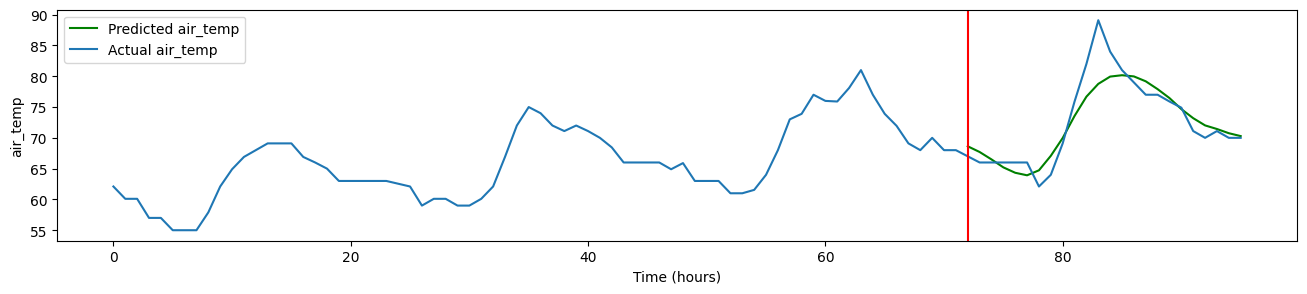

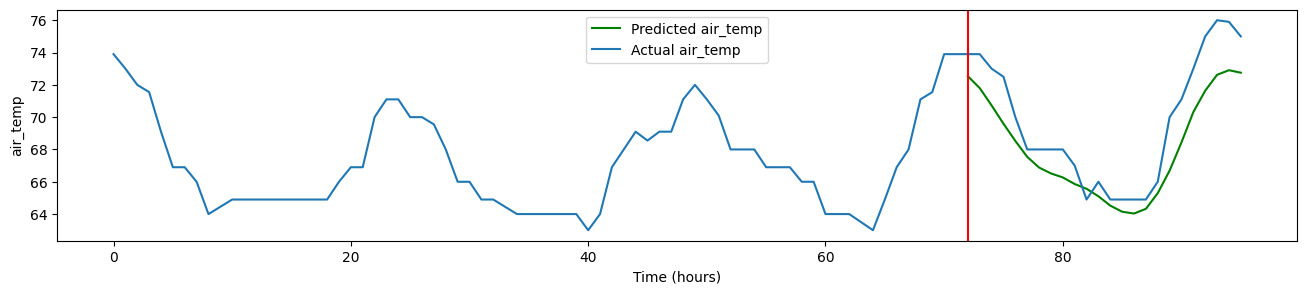

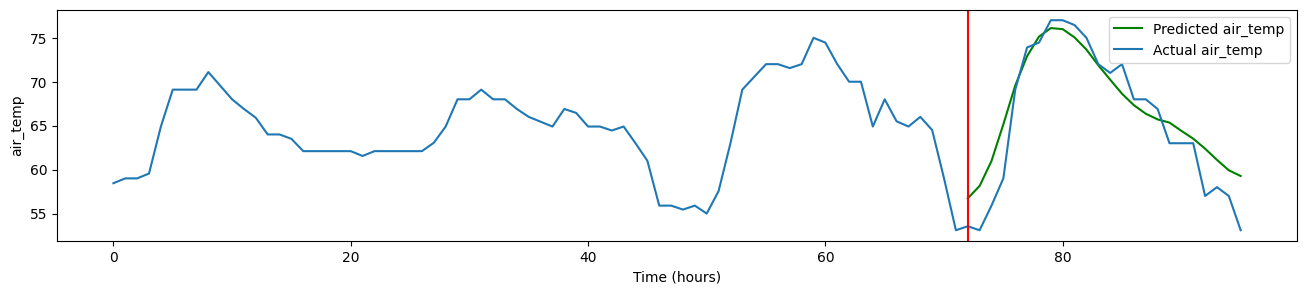

<Figure size 1600x300 with 0 Axes>

In [ ]:
for i in range(10):
    level_6.runner.plot_predictions_at_random_point()